This note book is created by Triveni Putti (UIN:656824532)

In [1]:
#Importing all the libraries we need
import plotly 
plotly.tools.set_credentials_file(username='tputti2', api_key='6DtlR3Gu6dTTVeVsI7yC')
import plotly.plotly as py
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pylab import *
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
#Loading the grants dataset
import os
import csv
os.getcwd()
df = {}
with open('Administrative_Discretionary_Grants__FY_1996-2014_.csv', "r", encoding="utf8") as f:
    reader = csv.reader(f)
    header = next(reader)
    for k in header:
        df[k] = []
    for row in reader:
        for k, v in zip(header, row):
            df[k].append(v)
#df.keys()

This notebook gives different summaries about IMLS grants. Before doing the analysis, little bit of cleaning is needed to be done on the data. Firstly, we remove the dollar sign from the amount fields ('Requested Award Amount'and'Total Amount Awarded and Disbursed') and convert them into float so that we can perform arithmetic operations on them later and use for plotting.

In [3]:
#Removing the dollar sign and converting the amount columns into float 
df["Amount awarded and disbursed"] = []
df["Amount requested"] = []
for value in df["Total Amount Awarded and Disbursed"]:
    new_data = value.strip('$')
    df["Amount awarded and disbursed"].append(float(new_data)) 
    
for value in df["Requested Award Amount"]:
    new_data1 = value.strip('$')
    df["Amount requested"].append(float(new_data1))
#df["Total Amount Awarded and Disbursed"],df["Amount awarded and disbursed"],df["Requested Award Amount"],df["Amount requested"]

Secondly, there are few wrong entries in the 'Program Type' field. For eg. 'MG' Program Type has Program names 'National Leadership Grants - Mu' and 'National Leadership Grants - Museums'. Clearly, 'National Leadership Grants - Mu' is wrongly entered in the database. Same is the case with Program types 'MH', 'NG', 'MN'. We will now correct these 4 entries in the database before proceeding further.


In [4]:
#Correcting the Program names
df= pd.DataFrame(df)
df = df.replace(['National Leadership Grants - Mu','Native American Library Service','Native American Native Hawaiian','Museum Grants African American'],['National Leadership Grants - Museums','Native American Library Services','Native American Native Hawaiian Museum Services Program','Museum Grants African American History and Culture'])
#set(df1["Program"]) 
#set(df1["Program Type"])

Next, we will define few functions that we might need to use in our analysis

In [5]:
class Dataset:
    def __init__(self, data):
        self.data = data.copy()
    
    def columns(self):
        return self.data.keys()
    
    def convert(self, column, dtype):
        self.data[column] = np.array(self.data[column], dtype=dtype)
        
    def filter_eq(self, column, value):
        good = (self.data[column] == value)
        new_data = {}
        for column in self.data:
            new_data[column] = self.data[column][good]
        return Dataset(new_data)

grants = Dataset(df)

value_types = {'Zip code': 'int',
               'Fiscal Year': 'int',
               'Amount awarded and disbursed': 'float',
               'Amount requested': 'float',
               }
for col in grants.columns():
    grants.convert(col, value_types.get(col, "str"))
#df

Starting with our analysis, let us first see how many unique program types does IMLS support every year and what are the different organizations that are awarded grants every year.

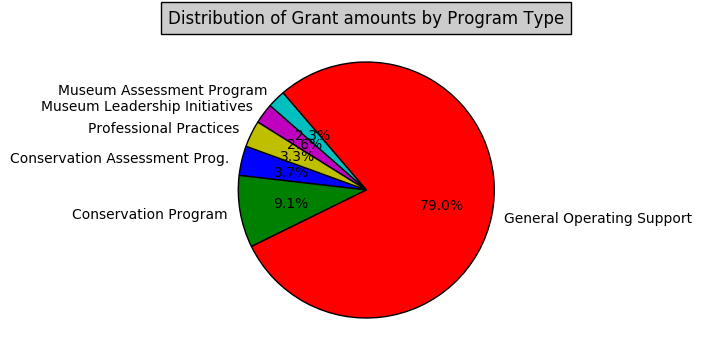

{'',
 'Aboretum',
 'Aquarium',
 'Art museum',
 "Children's/youth museum",
 'General museum',
 'Historic house/site',
 'History museum',
 'Institution of higher education',
 'Library',
 'Museum',
 'Museum Association',
 'Museum organization',
 'Natural history museum',
 'Other',
 'Professional association/Organization',
 'Research library/archives',
 'Science/technology museum',
 'Specialized museum',
 'State museum agency',
 'Zoo'}

In [6]:
def f1(Year):
    grants_df_year = grants.filter_eq('Fiscal Year',int(Year))
    grants_df_pd= pd.DataFrame(grants_df_year.data)
    grants_df_2 = grants_df_pd.groupby(['Program'])[['Amount awarded and disbursed']].sum()
    grants_new = {}
    grants_new.setdefault('Program', [])
    grants_new.setdefault('Amount awarded and disbursed', [])
    for x in grants_df_2.itertuples():
        grants_new['Program'].append(x[0])
        grants_new['Amount awarded and disbursed'].append(x[1])
    figure(1, figsize=(4,4))
    ax = axes([0.1, 0.1, 0.8,0.8])
    labels = grants_new['Program']
    sizes = grants_new['Amount awarded and disbursed']  
    #explode=(0, 0, 0, 0,0,0.5,0.5,0)
    pie(sizes, labels=labels, autopct='%1.1f%%', startangle=160)
    #plt.axis('equal')
    title('Distribution of Grant amounts by Program Type', bbox={'facecolor':'0.8', 'pad':5})
    show()
    return(set(grants_df_year.data['Organization Type']))
    
from ipywidgets import interact
import ipywidgets as widgets
grants_df= pd.DataFrame(grants.data)
year_list = sorted(np.array(grants_df['Fiscal Year'].unique()).tolist())
interact(f1, Year = year_list);

When you select the year, you can see a list of unique organisation types in the form of Dictionary and also a pie chart depicting  the programs present in the data for that year. I left the color scale to be default because number of programs change every year and we cannot manually specify a particular scale. I selected start angle as 160 because at 160, the program names on pie chart don't overlap for most of the years as opposed to other start angles where they do overlap making the chart look not so neat. One thing I wanted to do here was to represent the list of organisation types in the form of a visual. Clearly, pie chart is not a good option as it will look cluttered due to too many categories. I couldn't think of a better visualization for a metric with almost 40 categories hence I left it as a list. Moving on, we will now look at some trends across years. Trends will enable us to assess the progress of IMLS statewise.

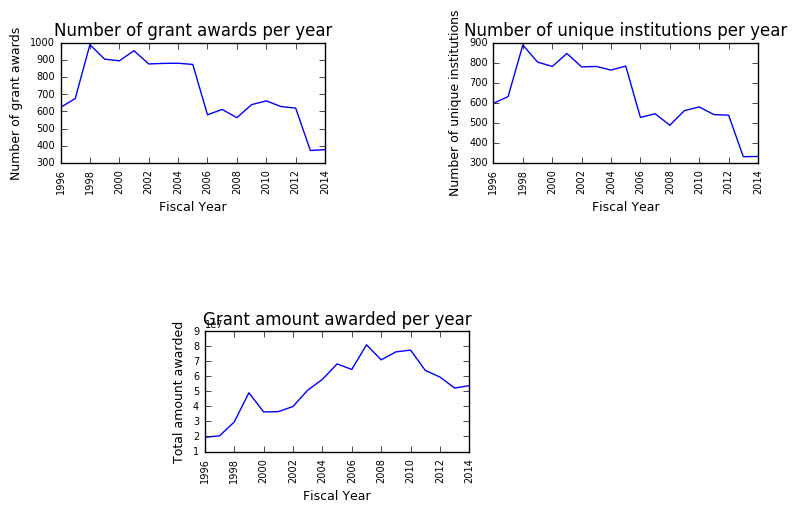

In [7]:
def f2(State):
    % matplotlib inline
    plt.rcParams["axes.labelsize"] = 9
    plt.rcParams["xtick.labelsize"] = 7
    plt.rcParams["ytick.labelsize"] = 7
    plt.rcParams["figure.figsize"] = [9,9]
    
    #Defining subplots
    ax1 = plt.subplot2grid((5,5), (1, 0), colspan=2)
    ax2 = plt.subplot2grid((5,5), (1, 3), colspan=2)
    ax3 = plt.subplot2grid((5,5), (3, 1), colspan=2)
        
    grants_df= pd.DataFrame(grants.data)
    if State == 'ALL STATES':
        #Plotting number of grant awards vs year
        grants_df_2 = grants_df.groupby(['Fiscal Year'])[['Log Number']].count().plot.line(rot = 90, ax= ax1)
        _ = grants_df_2.set(xlabel = 'Fiscal Year', ylabel = 'Number of grant awards',title = 'Number of grant awards per year')
        grants_df_2.legend().set_visible(False)
    
        #Plotting number of unique institutions vs year
        grants_df_3 = grants_df.groupby("Fiscal Year").agg({"Institution": pd.Series.nunique}).plot.line(rot=90, ax = ax2)
        _ = grants_df_3.set(xlabel = 'Fiscal Year', ylabel = 'Number of unique institutions',title = 'Number of unique institutions per year')
        grants_df_3.legend().set_visible(False)
        
        #Plotting amount awarded vs year
        grants_df_3 = grants_df.groupby("Fiscal Year")[['Amount awarded and disbursed']].sum().plot.line(rot=90, ax = ax3)
        _ = grants_df_3.set(xlabel = 'Fiscal Year', ylabel = 'Total amount awarded',title = 'Grant amount awarded per year')
        grants_df_3.legend().set_visible(False)
    else:
    
        grants_df_state = grants_df[(grants_df['State'] == State)]
    
        #Plotting number of grant awards vs year
        grants_df_2 = grants_df_state.groupby(['Fiscal Year'])[['Log Number']].count().plot.line(rot = 90, ax= ax1)
        _ = grants_df_2.set(xlabel = 'Fiscal Year', ylabel = 'Number of grant awards',title = 'Number of grant awards per year')
        grants_df_2.legend().set_visible(False)
    
        #Plotting number of unique institutions vs year
        grants_df_3 = grants_df_state.groupby("Fiscal Year").agg({"Institution": pd.Series.nunique}).plot.line(rot=90, ax = ax2)
        _ = grants_df_3.set(xlabel = 'Fiscal Year', ylabel = 'Number of unique institutions',title = 'Number of unique institutions per year')
        grants_df_3.legend().set_visible(False)
        
        #Plotting amount awarded vs year
        grants_df_3 = grants_df_state.groupby("Fiscal Year")[['Amount awarded and disbursed']].sum().plot.line(rot=90, ax = ax3)
        _ = grants_df_3.set(xlabel = 'Fiscal Year', ylabel = 'Total amount awarded',title = 'Grant amount awarded per year')
        grants_df_3.legend().set_visible(False)
    
    
from ipywidgets import interact
import ipywidgets as widgets
grants_df= pd.DataFrame(grants.data)
state_list = sorted(np.array(grants_df['State'].unique()).tolist())
state_list.append('ALL STATES')
interact(f2,State = state_list);

There seems to be an overall sense of decreasing trend in grants awards and institutions in almost all the states, although for some years there is an increase but if you try to fit a straight line for this trend, it will have a negative slope. It is interesting to see that the total amount awarded increases inspite of the decrease in the number of institutions. This graph helps to bring out this point.Also, if the user wants to look at the nation-level trend, there is an option of 'ALL STATES'. This visualization can tell us the progress of IMLS across years. Please note although the first two graphs look almost similar, in some cases their Y axis scale is different. Next,let's look at the difference between amount requested and amount awarded per year in every state to get an idea of how they vary. This plot can be found in other notebook (InteractivePlot_StateDiff.ipynb) under part-2. 

Since the data contains information at State level. In order to leverage that information, I created heat maps. In the next section, you will see two heat maps - one for number of Institutions and other for total amount granted (This is user choice). I tried to give as much control to the user as possible. So, there will be three drop down menus - Year, Program and metric. So, the heat map gives information about the metric for different years and different programs present in that year. There is an 'ALL' option in Program if the user does not want to look at it program-wise. One drawback of this approach is we cannot show non-US states like Northern Mariana Islands, Puerto Rico, U.S. Virgin Islands, Guam, District of Columbia, Micronesia, Marshall Islands, Palau,American Samoa. I tried to incorporate them into the heatmap by changing the location mode to global level but that did not work. I made use of plotly and interactive widgets for this plot. YOu will also see that I converted the dataset from dictionary to pandas and then back to dictionary to plot the heatmap because certain operations were easy to perform with the hwlp of pandas. 

In [8]:
scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

This is the color scale I chose to show my heatmap because I wanted the colors to be bright and different from the typical red and green heatmaps.

In [9]:
def f(Year,Program,Metric):
    #Converting grants data into a dataframe and applying groupby function
    grants_df= pd.DataFrame(grants.data)
    if Program =='ALL':
        grants_df_year = grants_df[(grants_df['Fiscal Year'] == int(Year))]
        grants_df_year['Program'] = 'All'
    else:
        grants_df_year = grants_df[(grants_df['Fiscal Year'] == int(Year)) & (grants_df['Program'] == Program)]
    grants_df_2 = grants_df_year.groupby(['State', 'Fiscal Year', 'Program']).agg({"Amount awarded and disbursed":np.sum,"Institution": pd.Series.nunique}) 
    
    #Converting grants_df_2 to a dictionary
    grants_new = {}
    grants_new.setdefault('State', [])
    grants_new.setdefault('Fiscal Year', [])
    grants_new.setdefault('Program', [])
    grants_new.setdefault('Amount awarded and disbursed', [])
    grants_new.setdefault('Institution', [])
    for x in grants_df_2.itertuples():
        grants_new['State'].append(x[0][0])
        grants_new['Fiscal Year'].append(x[0][1])
        grants_new['Program'].append(x[0][2])
        grants_new['Institution'].append(x[1])
        grants_new['Amount awarded and disbursed'].append(x[2])     
    
    #Creating Heat map using Plotly
    if Metric == "Grants":
        data = [ dict(
                type='choropleth',
                colorscale = scl,
                #hoverinfo='text',
                autocolorscale = False,
                locations = grants_new['State'],
                z = grants_new['Amount awarded and disbursed'],
                text = grants_new['Program'],
                locationmode = 'USA-states',
                marker = dict(
                    line = dict (
                        color = 'rgb(255,255,255)',
                        width = 2
                    ) ),
                colorbar = dict(
                    #autotick = False,
                    #tickprefix = '$',
                    title = "Total amount of grants awarded in USD"),
            ) ]
        layout = dict(
        title = 'Total number of grants awarded by State',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    else:
        data = [ dict(
                type='choropleth',
                colorscale = scl,
                #hoverinfo='text',
                autocolorscale = False,
                locations = grants_new['State'],
                z = grants_new['Institution'],
                text = grants_new['Program'],
                locationmode = 'USA-states',
                marker = dict(
                    line = dict (
                        color = 'rgb(255,255,255)',
                        width = 2
                    ) ),
                colorbar = dict(
                    #autotick = False,
                    #tickprefix = '$',
                    title = "Total number of unique institutions awarded"),
            ) ]
        layout = dict(
        title = 'Total number of unique awarded institutions by State',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
     
    fig = dict(data=data, layout=layout)
    return(py.iplot(fig, filename = 'heatmap_1'))
    

In [10]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
grants_df= pd.DataFrame(grants.data)
year_list = sorted(np.array(grants_df['Fiscal Year'].unique()).tolist())
program_list = sorted(np.array(grants_df['Program'].unique()).tolist())
program_list.append('ALL')
#widgets.SelectMultiple(
interact(f, Year = year_list, Program = program_list, Metric = ['Grants','Institution']);

Looking at the heat map, it seems that the top 2 states for highest number of institutions and also for the amount awarded are NY and CA. It is interesting to see IL in the top category. Please note if you find the heat map blank for a particular selection,it is because that combination does not exist in the data, please change the parameters. 

Lastly, I tried to find out economic related data at zip level from FRED website but I could find only at county level and I found it cumbersome to merge the two datasets based on county id. This note book is created by Triveni Putti.